In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
table = read_csv('/content/drive/MyDrive/Quadranti.csv')
Moggio = table.dropna(how="any")
Moggio

,Unnamed: 0,Date,Ammonia,PM10,PM25,Wind_speed,Temperature,Rainfall,Quadrante
0,0,2014-01-01T00:00:00Z,0.0,6.0,7.0,0.443554,-0.334965,0.0,2
1,1,2014-01-02T00:00:00Z,0.0,6.0,5.0,0.355915,-0.486111,7.8,2
2,2,2014-01-03T00:00:00Z,0.0,11.0,4.0,0.207631,2.220588,0.0,2
3,3,2014-01-04T00:00:00Z,0.0,6.0,7.0,1.024926,2.137063,35.8,2
4,4,2014-01-05T00:00:00Z,0.0,3.0,8.0,0.666721,2.416084,25.0,2
...,...,...,...,...,...,...,...,...,...
2523,2523,2020-12-27T00:00:00Z,0.0,4.0,5.0,0.314898,-3.706944,0.0,1
2524,2524,2020-12-28T00:00:00Z,0.0,2.0,5.0,0.345959,-3.006250,27.6,2
2525,2525,2020-12-29T00:00:00Z,0.0,2.0,0.0,1.031443,-0.051389,2.2,2
2526,2526,2020-12-30T00:00:00Z,0.0,0.0,0.0,0.029681,-0.549306,0.0,3


In [4]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#Moggio = Moggio.loc[:,["Date","Ammonia","PM10","PM25","Wind_speed","Wind_direction","Temperature","Rainfall"]]

Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:1667,:] # we train not using 2020, for now
Moggio = Moggio[['index','Unnamed: 0', 'Date','PM10','Ammonia', 'Wind_speed', 'Temperature','Rainfall', 'Quadrante']]

Moggio #Girare i posti delle variabili


,index,Unnamed: 0,Date,PM10,Ammonia,Wind_speed,Temperature,Rainfall,Quadrante
0,0,0,2014-01-01T00:00:00Z,6.0,0.0,0.443554,-0.334965,0.0,2
1,1,1,2014-01-02T00:00:00Z,6.0,0.0,0.355915,-0.486111,7.8,2
2,2,2,2014-01-03T00:00:00Z,11.0,0.0,0.207631,2.220588,0.0,2
3,3,3,2014-01-04T00:00:00Z,6.0,0.0,1.024926,2.137063,35.8,2
4,4,4,2014-01-05T00:00:00Z,3.0,0.0,0.666721,2.416084,25.0,2
...,...,...,...,...,...,...,...,...,...
1662,2112,2112,2019-11-09T00:00:00Z,5.0,0.1,0.248405,3.863889,0.0,2
1663,2113,2113,2019-11-10T00:00:00Z,5.0,0.1,0.374147,3.068056,0.0,2
1664,2114,2114,2019-11-11T00:00:00Z,6.0,0.2,0.307460,2.556250,21.6,3
1665,2115,2115,2019-11-12T00:00:00Z,0.0,0.1,0.181922,3.682639,20.2,1


##Convert series to supervised learning

###Conversion Function

In [5]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [ ]:
values = Moggio.iloc[:,3:].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)
print(reframed.shape)
reframed

(1662, 31)


,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
5,0.066667,0.000000,0.169316,0.286365,0.000000,0.333333,0.066667,0.000000,0.135178,0.282413,0.035199,0.333333,0.122222,0.000000,0.077417,0.353183,0.000000,0.333333,0.066667,0.000000,0.395778,0.350999,0.161552,0.333333,0.033333,0.000000,0.256247,0.358295,0.112816,0.333333,0.022222
6,0.066667,0.000000,0.135178,0.282413,0.035199,0.333333,0.122222,0.000000,0.077417,0.353183,0.000000,0.333333,0.066667,0.000000,0.395778,0.350999,0.161552,0.333333,0.033333,0.000000,0.256247,0.358295,0.112816,0.333333,0.022222,0.000000,0.078711,0.406390,0.000000,0.000000,0.077778
7,0.122222,0.000000,0.077417,0.353183,0.000000,0.333333,0.066667,0.000000,0.395778,0.350999,0.161552,0.333333,0.033333,0.000000,0.256247,0.358295,0.112816,0.333333,0.022222,0.000000,0.078711,0.406390,0.000000,0.000000,0.077778,0.000000,0.035589,0.397825,0.000000,0.000000,0.044444
8,0.066667,0.000000,0.395778,0.350999,0.161552,0.333333,0.033333,0.000000,0.256247,0.358295,0.112816,0.333333,0.022222,0.000000,0.078711,0.406390,0.000000,0.000000,0.077778,0.000000,0.035589,0.397825,0.000000,0.000000,0.044444,0.000000,0.208928,0.408315,0.000000,0.333333,0.044444
9,0.033333,0.000000,0.256247,0.358295,0.112816,0.333333,0.022222,0.000000,0.078711,0.406390,0.000000,0.000000,0.077778,0.000000,0.035589,0.397825,0.000000,0.000000,0.044444,0.000000,0.208928,0.408315,0.000000,0.333333,0.044444,0.000000,0.065975,0.392536,0.000000,0.000000,0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662,0.044444,0.024752,0.152218,0.514606,0.023466,0.333333,0.000000,0.059406,0.217469,0.501933,0.125451,0.666667,0.033333,0.009901,0.231993,0.415959,0.035199,0.333333,0.044444,0.000000,0.278818,0.388215,0.053249,0.333333,0.011111,0.000000,0.512671,0.381442,0.122744,0.333333,0.055556
1663,0.000000,0.059406,0.217469,0.501933,0.125451,0.666667,0.033333,0.009901,0.231993,0.415959,0.035199,0.333333,0.044444,0.000000,0.278818,0.388215,0.053249,0.333333,0.011111,0.000000,0.512671,0.381442,0.122744,0.333333,0.055556,0.004950,0.093300,0.396149,0.000000,0.333333,0.055556
1664,0.033333,0.009901,0.231993,0.415959,0.035199,0.333333,0.044444,0.000000,0.278818,0.388215,0.053249,0.333333,0.011111,0.000000,0.512671,0.381442,0.122744,0.333333,0.055556,0.004950,0.093300,0.396149,0.000000,0.333333,0.055556,0.004950,0.142280,0.375341,0.000000,0.333333,0.066667
1665,0.044444,0.000000,0.278818,0.388215,0.053249,0.333333,0.011111,0.000000,0.512671,0.381442,0.122744,0.333333,0.055556,0.004950,0.093300,0.396149,0.000000,0.333333,0.055556,0.004950,0.142280,0.375341,0.000000,0.333333,0.066667,0.009901,0.116304,0.361960,0.097473,0.666667,0.000000


In [ ]:
# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1667-365 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1302, 30) 1302 (1302,)
(1302, 5, 6) (1302,) (360, 5, 6) (360,)


# Modeling and training

In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.layers import RNN

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


Epoch 1/1000
27/27 - 25s - loss: 0.0372 - val_loss: 0.0198 - 25s/epoch - 925ms/step
Epoch 2/1000
27/27 - 3s - loss: 0.0182 - val_loss: 0.0149 - 3s/epoch - 101ms/step
Epoch 3/1000
27/27 - 3s - loss: 0.0188 - val_loss: 0.0145 - 3s/epoch - 103ms/step
Epoch 4/1000
27/27 - 2s - loss: 0.0175 - val_loss: 0.0136 - 2s/epoch - 78ms/step
Epoch 5/1000
27/27 - 1s - loss: 0.0151 - val_loss: 0.0124 - 1s/epoch - 41ms/step
Epoch 6/1000
27/27 - 1s - loss: 0.0142 - val_loss: 0.0130 - 1s/epoch - 41ms/step
Epoch 7/1000
27/27 - 1s - loss: 0.0138 - val_loss: 0.0140 - 1s/epoch - 41ms/step
Epoch 8/1000
27/27 - 1s - loss: 0.0137 - val_loss: 0.0149 - 1s/epoch - 41ms/step
Epoch 9/1000
27/27 - 1s - loss: 0.0142 - val_loss: 0.0136 - 1s/epoch - 40ms/step
Epoch 10/1000
27/27 - 1s - loss: 0.0145 - val_loss: 0.0119 - 1s/epoch - 42ms/step
Epoch 11/1000
27/27 - 1s - loss: 0.0127 - val_loss: 0.0110 - 1s/epoch - 43ms/step
Epoch 12/1000
27/27 - 1s - loss: 0.0105 - val_loss: 0.0113 - 1s/epoch - 40ms/step
Epoch 13/1000
27/27 

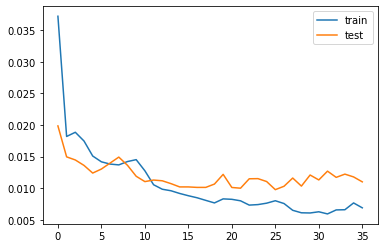

In [ ]:
# design network
model = Sequential()
model.add(RNN(tfa.rnn.LayerNormLSTMCell(50), return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(RNN(tfa.rnn.LayerNormLSTMCell(50), return_sequences=True))
model.add(RNN(tfa.rnn.LayerNormLSTMCell(50), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=10, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=1000, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
       def __init__(self, units, activation="tanh", **kwargs):         
         super().__init__(**kwargs)         
         self.state_size = units         
         self.output_size = units         
         self.simple_rnn_cell = tfa.rnn.LayerNormLSTMCell(units)                     
       def call(self, inputs, states):         
         outputs, new_states = self.simple_rnn_cell(inputs, states)                
         return outputs

## Predictions 

In [ ]:
# make a prediction using 2020 (not used for training or validation, and has different dynamics due to covid)
# adding back the data from 2020
Moggio = table.dropna(how="any")
Moggio = Moggio.reset_index()
#scaling and creating the new testing data
values = Moggio.iloc[:,3:].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)
# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 365 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 30) 365 (365,)
(365, 5, 6) (365,) (1662, 5, 6) (1662,)


In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.559


#### Prediciton plots

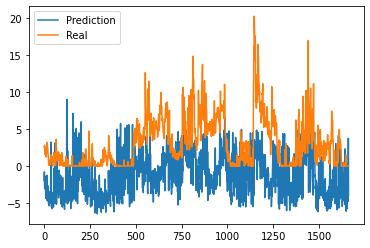

In [ ]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()